# 读取抓取数据

In [26]:
import pandas as pd
df = pd.read_csv("少数派sspai/1914010467.csv")
article=df["微博正文"]
likes=df["点赞数"]

# 生成词云

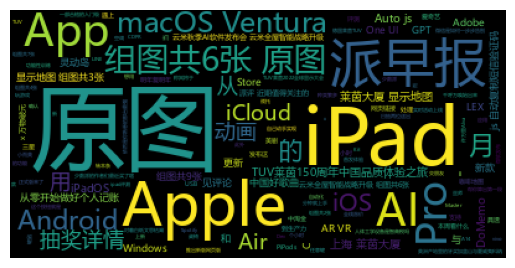

In [27]:
from wordcloud import WordCloud
import PIL .Image as image
text = " ".join(i for i in article)
wordcloud=WordCloud(font_path="msyh.ttc").generate(text)
word_image=wordcloud.to_image()
word_image.save('convert.png','png')
# 显示图片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

lena = mpimg.imread('convert.png')
plt.imshow(lena)
plt.axis('off')
plt.show()

# 帖子热度统计

In [ ]:
# 导入字体管理库
from matplotlib import font_manager
likes=df.loc[:,"点赞数"]
comment=df.loc[:,"评论数"]
forward=df.loc[:,"转发数"]
time=df.loc[:,"发布时间"]
my_font = font_manager.FontProperties(fname=r"msyh.ttc")
plt.figure(figsize=(15,8),dpi=80)
plt.plot(range(len(likes)), likes, label='点赞数',color="r")
plt.plot(range(len(comment)), comment, label='评论数',color="b")
plt.plot(range(len(forward)), forward, label='转发数',color="y")
# 设置x，y坐标
plt.xticks(time)
plt.yticks(range(500))
# 设置网格线
plt.grid(alpha=0.2)
plt.legend(prop=my_font,loc="upper left")
plt.title('微博热度折线图',fontproperties=my_font)
plt.show()
plt.savefig('./hot.png')



# 爬取微博热搜

In [24]:
# 导入库
import pandas as pd

wb_hot_data = pd.read_html('summary.html',index_col=0)[0]
# from fake_useragent import UserAgent
# from urllib.request import Request,urlopen
# from urllib.parse import quote
# from urllib.parse import urlencode
# url = "https://s.weibo.com/top/summary/summary"
# response = urlopen(url)
# info = response.read()
# info.decode()
# 重新设置表头
wb_hot_data.columns = ['wb_title_hot', 'wb_lable']
# 简单处理数据，去除推荐热搜和置顶热搜
print(wb_hot_data.dtypes)


import requests, os, datetime, time
from lxml import etree

# 定义请求头
headers = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36'
        }


def WeiboHot():
    try:
        url = 'https://s.weibo.com/top/summary'
        Response = requests.get(url, headers)
        # 将响应内容设置为二进制utf-8编码
        content = Response.content.decode('utf-8')
        # 对编码后的内容用etree进行HTML解码
        html = etree.HTML(content)
        # 对解码后的内容使用Xpath语法匹配信息
        trs = html.xpath('//*[@id="pl_top_realtimehot"]/table/tbody/tr[position()>1]')
    except:
        print("微博数据获取错误")

    try:
        hots = []
        for tr in trs: # 还有另一种方法是用keywords和hots两个xpath匹配了之后，使用zip()函数一次遍历两组的内容 for keyword,hot in zip(keywords,hots):
            dictory = {}
            keyword = tr.xpath('.//a/text()')[0] # 因为此时text出来的是一个列表，需要把列表内的字符提取出来用[0]
            hot = tr.xpath('.//span/text()')[0]
            dictory = {
                "keyword": keyword,
                "hot": hot
            }
            hots.append(dictory)
        return hots
    except:
        print("信息解析错误")


if __name__ == '__main__':
    try:
        if not os.path.exists('./saves'):   # 判断是否存在saves文件夹，不存在就新建一个
            os.mkdir('./saves')
    except:
        print("创建文件夹失败")
    try:
        while True: # 这个程序中的这个部分在不停的循环
            # 将获取时间放在这里，使得一直循环的过程中一直计算当前时间
            time.sleep(1)
            now_time = datetime.datetime.now()
            file_name = str(now_time.year) + str(now_time.month) + str(now_time.day) + str(now_time.hour) + str(
                now_time.minute)+ str(now_time.second) + ".txt"
            file_path = './saves' + '/' + file_name

            # 设置5秒一次，这时就要注意上面的文件名会不会变化，如果没有加second就可能导致无法使用生成文件
            if now_time.second % 2 == 0:  # 设置2秒一次
                if not os.path.exists(file_path): # 配合着上面的时间，就可以做到一分钟一个
                    hots = WeiboHot() # 获得需要的信息
                    # 以写入模式打开，如果存在file_path就打开，不存在就创建一个file_path
                    file = open(file_path, 'w')
                    file.write(str(hots)) # txt中要求str格式，转换一下
                    file.close() # 写完之后关闭文件，节省内存
                    print(f'已生成{file_name}\n')
    except:
        print('数据写入错误')


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xca in position 339: invalid continuation byte